In [1]:
import os
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import re

mandli_data_test_dir_path = '/cs6945share/mandli_data/0008_+'

# Misc Notes
- I believe F_* means full size image while R_* means reduced size image
- LCMS is Laser Crack Measurement System which is what was used to collect road distress and related information (here: Laser Crack Measurement System)
    - The manual was obtained directly from Mandli, could not see a direct way to get hold of the manual on their website, I used a manual titled '202108_LCMS_DataAnalyser_Manual_v4.71.5.pdf'
- I believe that the "Type" of a node may be this: 
"The pavement type, as defined by the user. This setting will be ignored if the automatic pavement type detection is enabled. Possible values are: 1: Asphalt
2: Concrete
3: Grooved concrete (transversally)
4: Grooved concrete (longitudinally)
5: Highly textured (or porous)
6: Concrete CRCP (CRCP = Continuously Reinforced Concrete Pavement). *Concrete CRCP is concrete pavement with no transversal joints. The library is looking only for longitudinal joints when the pavement type is set"


In [2]:
os.listdir(mandli_data_test_dir_path)

# Front view monolcular images are contained here
front_view_test_dir_path = os.path.join(mandli_data_test_dir_path, '0008_+/Front')
print(os.listdir(front_view_test_dir_path))

LCMS_distress_test_dir_path = os.path.join(mandli_data_test_dir_path, 'LCMSDistress')
print(os.listdir(LCMS_distress_test_dir_path))

LCMS_visual_rng_test_dir_path = os.path.join(mandli_data_test_dir_path, '0008_+/RngOverlay_Down')
print(os.listdir(LCMS_visual_rng_test_dir_path))

LCMS_rng_test_dir_path = os.path.join(mandli_data_test_dir_path, '0008_+/Rng_Down')
print(os.listdir(LCMS_rng_test_dir_path))


['Dir_001', 'Dir_003', 'Dir_000', 'Dir_002']
['F_000316.xml', 'F_000312.xml', 'F_000071.xml', 'F_000224.xml', 'F_000029.xml', 'F_000237.xml', 'F_000088.xml', 'F_000098.xml', 'F_000117.xml', 'F_000269.xml', 'F_000154.xml', 'F_000205.xml', 'F_000097.xml', 'F_000275.xml', 'F_000245.xml', 'F_000173.xml', 'F_000139.xml', 'F_000132.xml', 'F_000169.xml', 'F_000102.xml', 'F_000279.xml', 'F_000016.xml', 'F_000147.xml', 'F_000270.xml', 'F_000032.xml', 'F_000063.xml', 'F_000255.xml', 'F_000105.xml', 'F_000080.xml', 'F_000263.xml', 'F_000138.xml', 'F_000267.xml', 'F_000053.xml', 'F_000185.xml', 'F_000305.xml', 'F_000157.xml', 'F_000144.xml', 'F_000288.xml', 'F_000309.xml', 'F_000001.xml', 'F_000083.xml', 'F_000040.xml', 'F_000134.xml', 'F_000291.xml', 'F_000242.xml', 'F_000081.xml', 'F_000182.xml', 'F_000093.xml', 'F_000301.xml', 'F_000229.xml', 'F_000060.xml', 'F_000297.xml', 'F_000089.xml', 'F_000261.xml', 'F_000218.xml', 'F_000266.xml', 'F_000300.xml', 'F_000145.xml', 'F_000304.xml', 'F_000264.

# Visualizing Mandli Data
Below shows how Mandli data front dashcam images and LCMS data line up, looking at the manhole cover it can be seen that the LCMS rng data is much closer to the bottom of the dashcam images and past a certain distance it ends up in the back of the LCMS data for the next frame.

The horizontal crack at the bottom of the image of 00228 shows how the bottom of the image frame lines up with the rng LCMS data.

The Manhole cover of the image of 00227 almost appears on 00227's LCMS data at the very top but appears in the LCMS rng data of 00228.

In summary, roughly the bottom half of a mandli front view image lines up with the top half of the corresponding LCMS rng data.
Translation to visualization given same size both front and rng images (and assuming camera perspective is fixed for all images) is **approximately (upon manual inspection)**:

front image reduced size: y=0 ====> rng image full size: y=763

front image reduced size: y=310 ====> rng image full size: y=2012

Front img shape: (1024, 540, 3)
LCMS visual img shape: (2013, 1018, 3)
LCMS img shape: (2013, 1018, 3)


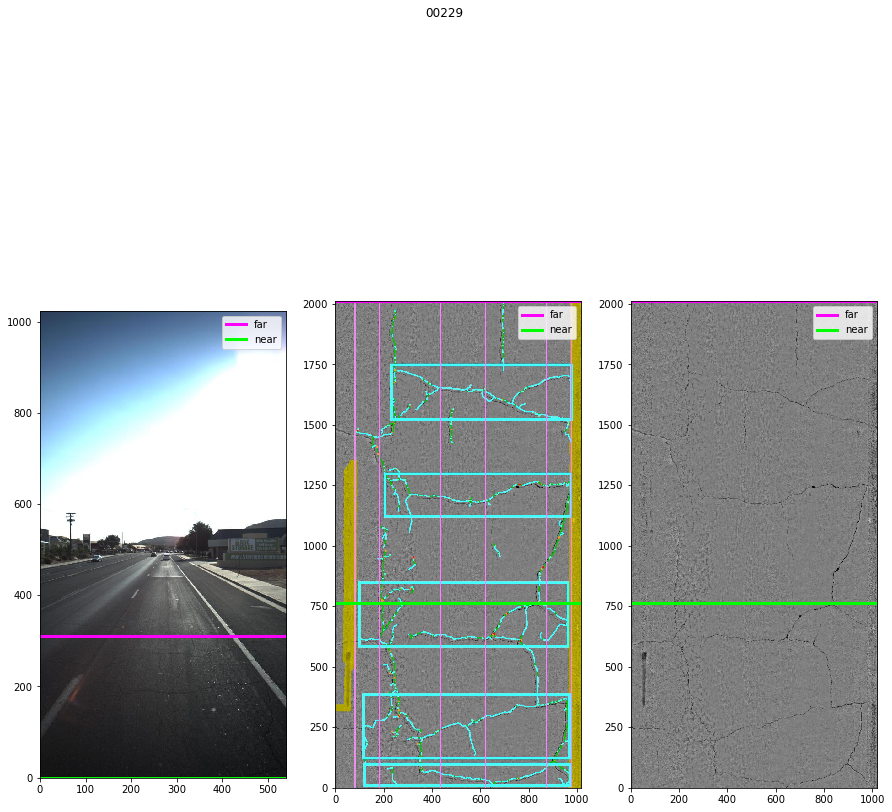

Front img shape: (1024, 540, 3)
LCMS visual img shape: (2013, 1018, 3)
LCMS img shape: (2013, 1018, 3)


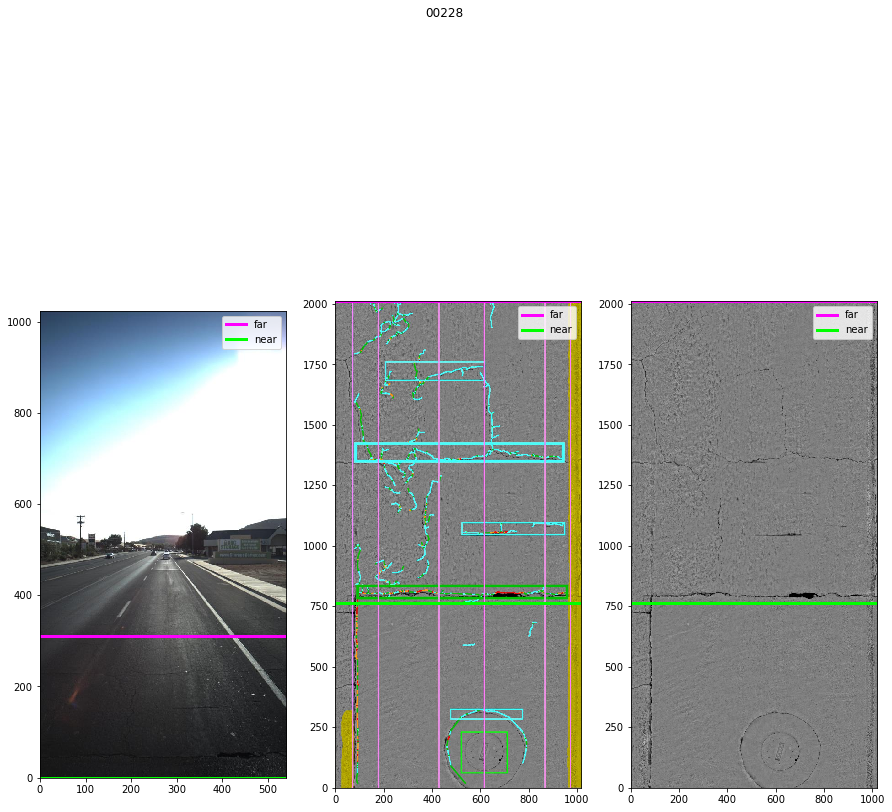

Front img shape: (1024, 540, 3)
LCMS visual img shape: (2013, 1018, 3)
LCMS img shape: (2013, 1018, 3)


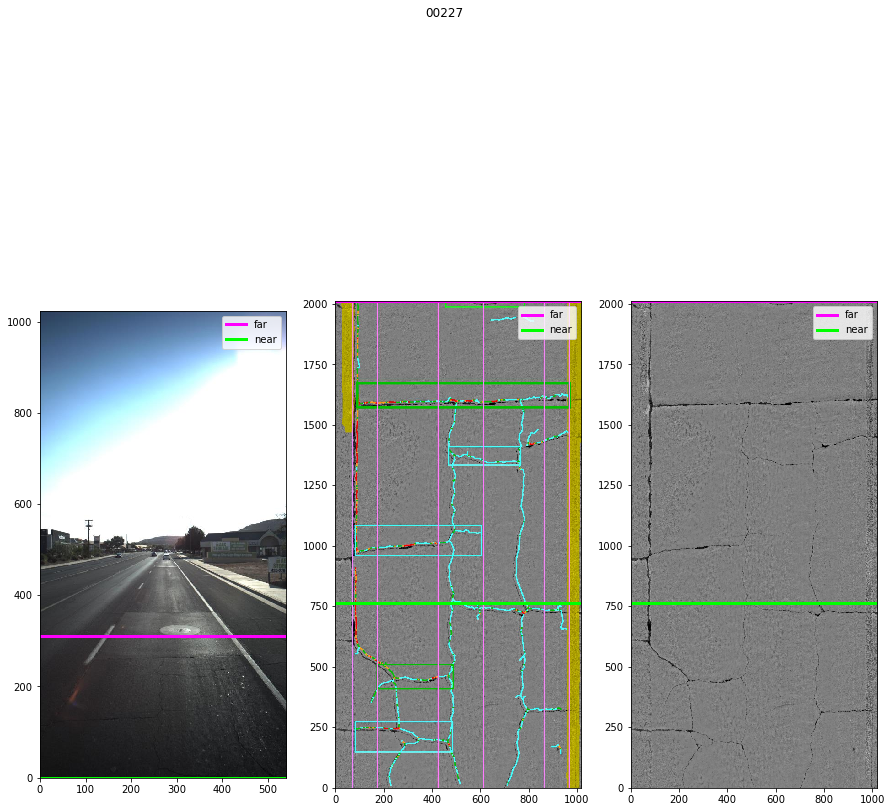

In [3]:
def get_front_img_filepaths(mandli_data_dir_path, name):
    return glob.glob(os.path.join(os.path.join(mandli_data_dir_path, '0008_+/Front'), '*/R_{0}.jpg'.format(name)), recursive=True)

def get_LCMS_distress_filepaths(mandli_data_dir_path, name):
    return glob.glob(os.path.join(os.path.join(mandli_data_dir_path, 'LCMSDistress'), '*_0{0}.xml'.format(name)), recursive=True)

def get_LCMS_visual_rng_filepaths(mandli_data_dir_path, name):
    return glob.glob(os.path.join(os.path.join(mandli_data_dir_path, '0008_+/RngOverlay_Down'), '*/F_{0}.jpg'.format(name)), recursive=True)

def get_LCMS_rng_filepaths(mandli_data_dir_path, name):
    return glob.glob(os.path.join(os.path.join(mandli_data_dir_path, '0008_+/Rng_Down'), '*/F_{0}.jpg'.format(name)), recursive=True)

def plot_front_and_visual_rng_and_rng(filename, mandli_data_dir_path, rng_extra_plotting_func=None, print_shape=False, figsize=(20,20), near_viz_color='lime', far_viz_color='magenta', viz_linestyle= '-', viz_linewidth=3, legend_loc=[None,None,None], suptitle_pos=1, suptitle_fontsize='large'):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    file_front_img = get_front_img_filepaths(mandli_data_dir_path, filename)[0]
    front_img = np.flipud(plt.imread(file_front_img))
    ax1.imshow(front_img, origin='lower')
    ax1.axhline(y=310, color=far_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='far')
    ax1.axhline(y=0, color=near_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='near')

    file_LCMS_visual_rng_img = get_LCMS_visual_rng_filepaths(mandli_data_dir_path, filename)[0]
    LCMS_visual_rng_img = np.flipud(plt.imread(file_LCMS_visual_rng_img))
    ax2.imshow(LCMS_visual_rng_img, origin='lower')
    ax2.axhline(y=2012, color=far_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='far')
    ax2.axhline(y=763, color=near_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='near')

    file_LCMS_rng_img = get_LCMS_rng_filepaths(mandli_data_dir_path, filename)[0]
    LCMS_rng_img = np.flipud(plt.imread(file_LCMS_rng_img))
    ax3.imshow(LCMS_rng_img, origin='lower')
    ax3.axhline(y=2012, color=far_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='far')
    ax3.axhline(y=763, color=near_viz_color, linestyle=viz_linestyle, linewidth=viz_linewidth, label='near')

    if rng_extra_plotting_func is not None:
        rng_extra_plotting_func(filename, fig, ax1, ax2, ax3)

    if print_shape:
        print('Front img shape: {0}'.format(front_img.shape))
        print('LCMS visual img shape: {0}'.format(LCMS_visual_rng_img.shape))
        print('LCMS img shape: {0}'.format(LCMS_rng_img.shape))

    ax1.legend(loc=legend_loc[0])
    ax2.legend(loc=legend_loc[1])
    ax3.legend(loc=legend_loc[2])
    fig.suptitle(filename, y=suptitle_pos, fontsize=suptitle_fontsize)
    fig.show()
    plt.show()
        
test_files_names = ['00227', '00228', '00229']
test_files_names.reverse() # Reverse so viz appears as driving forward
for test_files_name in test_files_names:
    plot_front_and_visual_rng_and_rng(test_files_name, mandli_data_test_dir_path, figsize=(15,15), print_shape=True)


# Parse XML for Cracks
Useful info the manual: 

- "The actual crack detection information is in the \<CrackList> element. The crack list may contain any number of \<Crack>. A \<Crack> has an identifier (\<CrackID>), a crack length (\<Length>) and a list of connected \<Node>. A \<Crack> element always has at least two \<Node>. A \<Node> is a point along a crack. It is defined by two coordinates (\<X> and \<Y>), a \<Width> value and a \<Depth> value. The \<Width> and \<Depth> values are the average severity and depth of the crack between two successive nodes. The node coordinates \<X> and \<Y> are given with respect to the lower-left corner of the result images (see LcmsGetResultImage documentation in Section 7.27). In order to determine the exact match between the \<X> and \<Y> coordinates of a crack from the XML file and the pixel coordinates of the same crack in the result images, one must use the GeneralParam_ResultImageResolution_mm parameter (see Section 6.1)."

- All (X,Y) coordinates are returned with respect to the lower-left corner of the road section result image

- In order to determine the exact match between the position of a joint in the XML file and its coordinates in pixel in the result images, one must use the GeneralParam_ResultImageResolution_mm parameter.
    - Note: I assume this GeneralParam_ResultImageResolution_mm parameter is the mm of the width an height of an image pixel 

In [8]:
def LCMS_crack_data_extraction(LCMS_distress_filepath, should_give_crack_node_info=True):
    root = ET.parse(LCMS_distress_filepath).getroot()
    
    ProcessingParameters_tree = root.find('ProcessingInformation').find('ProcessingParameters')
    image_pixel_resolution_in_mm = float(ProcessingParameters_tree.find('GeneralParam_ResultImageResolution_mm').text)
        
    desired_crack_unit_info={'X', 'Y', 'Width', 'Depth', 'Length', 'BoundingBox', 'MaxCrackWidth'}

    
    # CrackList information, specific view on all registered cracks
    CrackInformation_tree = root.findall('CrackInformation')
    if not (len(CrackInformation_tree) == 1):
        print('No cracks found for {0}'.format(LCMS_distress_filepath))
        return
    CrackInformation_tree = CrackInformation_tree[0]
    
    CrackInformationUnit_tree = CrackInformation_tree.find('Unit')
    unit_dict = {}

    for child in CrackInformationUnit_tree:
        if not child.tag in desired_crack_unit_info:
            continue
        unit_dict[child.tag] = child.text
        
    CrackList_tree = CrackInformation_tree.find('CrackList')
    
    crack_list_dict = {}
    for crack_tree in CrackList_tree.findall('Crack'):
        crack_info = {}
        crack_info['Length'] = float(crack_tree.find('Length').text)
        crack_info['WeightedDepth'] = float(crack_tree.find('WeightedDepth').text)
        crack_info['WeightedWidth'] = float(crack_tree.find('WeightedWidth').text)
        if should_give_crack_node_info:
            crack_info['X'], crack_info['Y'], crack_info['Width'], crack_info['Depth'], crack_info['Type'] = extract_crack_node_info(crack_tree)
            crack_info['X_pixel'] = np.rint(crack_info['X']/image_pixel_resolution_in_mm)
            crack_info['Y_pixel'] = np.rint(crack_info['Y']/image_pixel_resolution_in_mm)

        crack_list_dict[crack_tree.find('CrackID').text] = crack_info

        
    # CrackClassification information, macroscopic view on cracks
    CrackClassification_tree = root.find('CrackClassification')
    CrackClassificationUnit_tree = CrackClassification_tree.find('Unit')
    for child in CrackClassificationUnit_tree:
        if not child.tag in desired_crack_unit_info:
            continue
        unit_dict[child.tag] = child.text
    
    crack_classification_types_to_extractor_dict = {'MultipleCracks':extract_multiple_crack_info, 'Alligators':extract_alligator_crack_info, 'Transversals':extract_transverals_crack_info}
    crack_classification_dict = {}
    
    for crack_classification_type in crack_classification_types_to_extractor_dict:
        type_tree = CrackClassification_tree.find(crack_classification_type)
        if type_tree is None:
            continue
        type_info_list = crack_classification_types_to_extractor_dict[crack_classification_type](type_tree, image_pixel_resolution_in_mm)
        crack_classification_dict[crack_classification_type] = type_info_list
    
    return image_pixel_resolution_in_mm, unit_dict, crack_list_dict, crack_classification_dict

def extract_multiple_crack_info(MultipleCracks_tree, image_pixel_resolution):
    multiple_crack_list = []
    for MultipleCrackRegion_tree in MultipleCracks_tree.findall('MultipleCrackRegion'):
        MultipleCrackRegion_dict = {}
        extract_bounding_box_info_to_dict(MultipleCrackRegion_tree, MultipleCrackRegion_dict, get_pixel_values=True, image_pixel_resolution=image_pixel_resolution)
        multiple_crack_list.append(MultipleCrackRegion_dict)
    return multiple_crack_list

def extract_alligator_crack_info(Alligators_tree, image_pixel_resolution):
    alligator_crack_list = []
    for AlligatorRegion_tree in Alligators_tree.findall('AlligatorRegion'):
        AlligatorRegion_dict = {}
        AlligatorRegion_dict['MaxCrackWidth'] = float(AlligatorRegion_tree.find('MaxCrackWidth').text)
        extract_bounding_box_info_to_dict(AlligatorRegion_tree, AlligatorRegion_dict, get_pixel_values=True, image_pixel_resolution=image_pixel_resolution)
        alligator_crack_list.append(AlligatorRegion_dict)
    return alligator_crack_list

def extract_transverals_crack_info(Transversals_tree, image_pixel_resolution):
    transversals_crack_list = []
    for TransversalCrack_tree in Transversals_tree.findall('TransversalCrack'):
        TransversalCrack_dict = {}
        TransversalCrack_dict['Type'] = TransversalCrack_tree.find('Type').text
        TransversalCrack_dict['Severity'] = TransversalCrack_tree.find('Severity').text
        extract_bounding_box_info_to_dict(TransversalCrack_tree, TransversalCrack_dict, get_pixel_values=True, image_pixel_resolution=image_pixel_resolution)
        transversals_crack_list.append(TransversalCrack_dict)
    return transversals_crack_list

def extract_bounding_box_info_to_dict(tree, dict_to_use, get_pixel_values=False, image_pixel_resolution=None):
    for child in tree.find('BoundingBox'):
        childtag = child.tag
        value = float(child.text)
        dict_to_use[childtag] = value
        dict_to_use[(childtag + '_pixel')] = int(np.rint(value/image_pixel_resolution))
    
def extract_crack_node_info(crack_tree):
    x_list = []
    y_list = []
    width_list =[] 
    depth_list = []
    type_list = []
    for node_tree in crack_tree.findall('Node'):
        x_list.append(node_tree.find('X').text)
        y_list.append(node_tree.find('Y').text)
        width_list.append(node_tree.find('Width').text)
        depth_list.append(node_tree.find('Depth').text)
        type_list.append(node_tree.find('Type').text)
    return np.array(x_list, dtype=np.float), np.array(y_list, dtype=np.float), np.array(width_list, dtype=np.float), np.array(depth_list, dtype=np.float), np.array(type_list, dtype=np.float)
    

I think '2': {'Length': '3.37',
   'WeightedDepth': '5.37',
   'WeightedWidth': '14.28',
   'random_x_on_crack_mm': '410.0',
   'random_y_on_crack_mm': '3320.0'}, is the long crack, bottom of image, middle of LCMS data crack in 0028
   
   
   
   
End goal is to get some (front view) images labelled (can use segmenting tool) and associate segments with ground truth crack dimensions.

Just need to find some good examples, so can be a rough heuristic, maybe just look at cracks that are over a certain length and fall on the bottom y values of the scan (because of how images line up with scan) and maybe also calculate statistics over the ``nodes''



QUESTIONS:

- How much data (in folder structure given) can I get?
- What exaactly is "WeightedDepth" and "WeightedWidth" of a Crack, and what is "Type" of a Node?

In [9]:
def viz_crack(filename, fig, ax1, ax2, ax3, crack_classification_dict):
    MultipleCracks_info = crack_classification_dict['MultipleCracks']
    Alligators_info = crack_classification_dict['Alligators']
    Transversals_info = crack_classification_dict['Transversals']
    cmap = get_cmap(len(MultipleCracks_info)+len(Alligators_info)+len(Transversals_info))
    i = 0
    for single_crack_classification_info_dict in MultipleCracks_info:
        viz_bounding_box(ax3, single_crack_classification_info_dict, linewidth=1, edgecolor=cmap(i), facecolor='none', name='\"MultipleCracks\"')
        i += 1
    for single_crack_classification_info_dict in Alligators_info:
        viz_bounding_box(ax3, single_crack_classification_info_dict, linewidth=1, edgecolor=cmap(i), facecolor='none', name='\"Alligators\"')
        i += 1
    for single_crack_classification_info_dict in Transversals_info:
        legend_string = '\"Transversals\", Type:{0} Severity:{1}'.format(single_crack_classification_info_dict['Type'], single_crack_classification_info_dict['Severity'])
        viz_bounding_box(ax3, single_crack_classification_info_dict, linewidth=1, edgecolor=cmap(i), facecolor='none', name=legend_string)
        i += 1

        
# https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def viz_bounding_box(ax, single_crack_classification_info_dict, linewidth=1, edgecolor='r', facecolor='none', name=None):
    x = single_crack_classification_info_dict['MinX_pixel']
    y = single_crack_classification_info_dict['MinY_pixel']
    width = single_crack_classification_info_dict['MaxX_pixel'] - x
    height = single_crack_classification_info_dict['MaxY_pixel'] - y
    rect = patches.Rectangle((x,y), width, height, linewidth=linewidth, edgecolor=edgecolor, facecolor=facecolor, label=name)
    ax.add_patch(rect)

{'MultipleCracks': [{'MinX': 735.0, 'MinX_pixel': 184, 'MaxX': 1735.0, 'MaxX_pixel': 434, 'MinY': 885.0, 'MinY_pixel': 221, 'MaxY': 1694.0, 'MaxY_pixel': 424}, {'MinX': 735.0, 'MinX_pixel': 184, 'MaxX': 1735.0, 'MaxX_pixel': 434, 'MinY': 1850.0, 'MinY_pixel': 462, 'MaxY': 2000.0, 'MaxY_pixel': 500}, {'MinX': 735.0, 'MinX_pixel': 184, 'MaxX': 1735.0, 'MaxX_pixel': 434, 'MinY': 2845.0, 'MinY_pixel': 711, 'MaxY': 3090.0, 'MaxY_pixel': 772}, {'MinX': 735.0, 'MinX_pixel': 184, 'MaxX': 1735.0, 'MaxX_pixel': 434, 'MinY': 4535.0, 'MinY_pixel': 1134, 'MaxY': 5240.0, 'MaxY_pixel': 1310}, {'MinX': 735.0, 'MinX_pixel': 184, 'MaxX': 1735.0, 'MaxX_pixel': 434, 'MinY': 5889.0, 'MinY_pixel': 1472, 'MaxY': 6300.0, 'MaxY_pixel': 1575}, {'MinX': 2485.0, 'MinX_pixel': 621, 'MaxX': 3485.0, 'MaxX_pixel': 871, 'MinY': 2853.0, 'MinY_pixel': 713, 'MaxY': 3034.0, 'MaxY_pixel': 758}, {'MinX': 2485.0, 'MinX_pixel': 621, 'MaxX': 3485.0, 'MaxX_pixel': 871, 'MinY': 6245.0, 'MinY_pixel': 1561, 'MaxY': 6415.0, 'MaxY_p

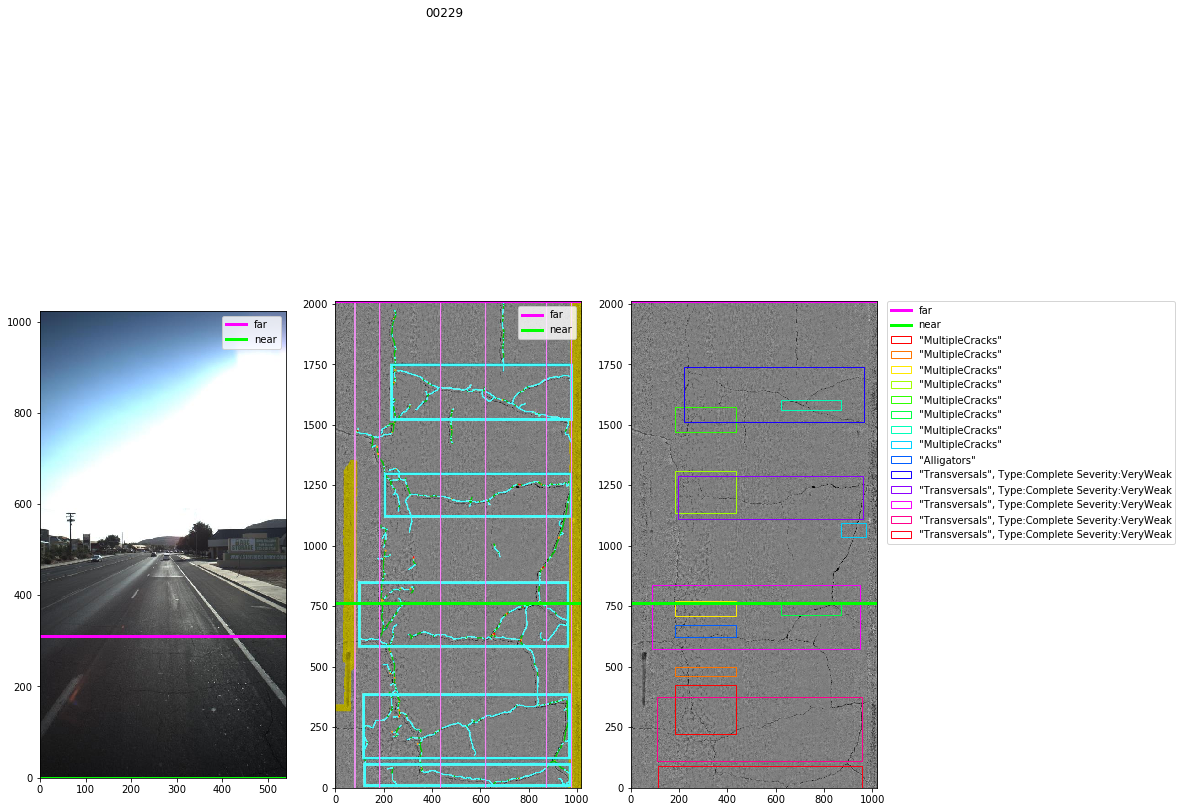

{'MultipleCracks': [{'MinX': 290.0, 'MinX_pixel': 72, 'MaxX': 710.0, 'MaxX_pixel': 178, 'MinY': 3170.0, 'MinY_pixel': 792, 'MaxY': 3483.0, 'MaxY_pixel': 871}, {'MinX': 710.0, 'MinX_pixel': 178, 'MaxX': 1710.0, 'MaxX_pixel': 428, 'MinY': 4356.0, 'MinY_pixel': 1089, 'MaxY': 5083.0, 'MaxY_pixel': 1271}, {'MinX': 710.0, 'MinX_pixel': 178, 'MaxX': 1710.0, 'MaxX_pixel': 428, 'MinY': 6629.0, 'MinY_pixel': 1657, 'MaxY': 6784.0, 'MaxY_pixel': 1696}, {'MinX': 710.0, 'MinX_pixel': 178, 'MaxX': 1710.0, 'MaxX_pixel': 428, 'MinY': 7438.0, 'MinY_pixel': 1860, 'MaxY': 7970.0, 'MaxY_pixel': 1992}], 'Alligators': [{'MaxCrackWidth': 15.8, 'MinX': 710.0, 'MinX_pixel': 178, 'MaxX': 1710.0, 'MaxX_pixel': 428, 'MinY': 5140.0, 'MinY_pixel': 1285, 'MaxY': 5490.0, 'MaxY_pixel': 1372}], 'Transversals': [{'Type': 'Incomplete', 'Severity': 'VeryWeak', 'MinX': 794.0, 'MinX_pixel': 198, 'MaxX': 2428.0, 'MaxX_pixel': 607, 'MinY': 6700.0, 'MinY_pixel': 1675, 'MaxY': 7000.0, 'MaxY_pixel': 1750}, {'Type': 'Complete', 'S

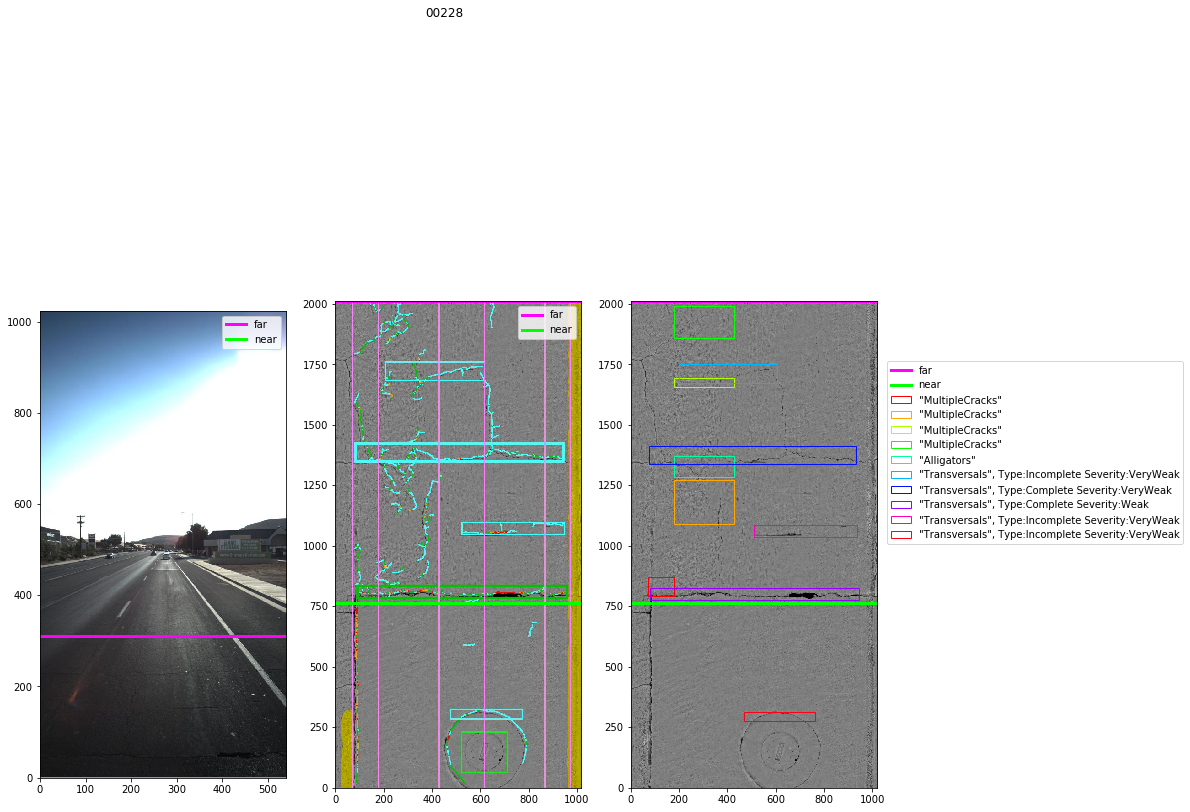

{'MultipleCracks': [{'MinX': 2449.0, 'MinX_pixel': 612, 'MaxX': 3449.0, 'MaxX_pixel': 862, 'MinY': 1255.0, 'MinY_pixel': 314, 'MaxY': 1488.0, 'MaxY_pixel': 372}, {'MinX': 2449.0, 'MinX_pixel': 612, 'MaxX': 3449.0, 'MaxX_pixel': 862, 'MinY': 5625.0, 'MinY_pixel': 1406, 'MaxY': 5880.0, 'MaxY_pixel': 1470}], 'Alligators': [], 'Transversals': [{'Type': 'Complete', 'Severity': 'Weak', 'MinX': 324.0, 'MinX_pixel': 81, 'MaxX': 3823.0, 'MaxX_pixel': 956, 'MinY': 6250.0, 'MinY_pixel': 1562, 'MaxY': 6650.0, 'MaxY_pixel': 1662}, {'Type': 'Incomplete', 'Severity': 'VeryWeak', 'MinX': 290.0, 'MinX_pixel': 72, 'MaxX': 2372.0, 'MaxX_pixel': 593, 'MinY': 3800.0, 'MinY_pixel': 950, 'MaxY': 4300.0, 'MaxY_pixel': 1075}, {'Type': 'Incomplete', 'Severity': 'Weak', 'MinX': 653.0, 'MinX_pixel': 163, 'MaxX': 1907.0, 'MaxX_pixel': 477, 'MinY': 1600.0, 'MinY_pixel': 400, 'MaxY': 2000.0, 'MaxY_pixel': 500}, {'Type': 'Incomplete', 'Severity': 'VeryWeak', 'MinX': 290.0, 'MinX_pixel': 72, 'MaxX': 1894.0, 'MaxX_pixe

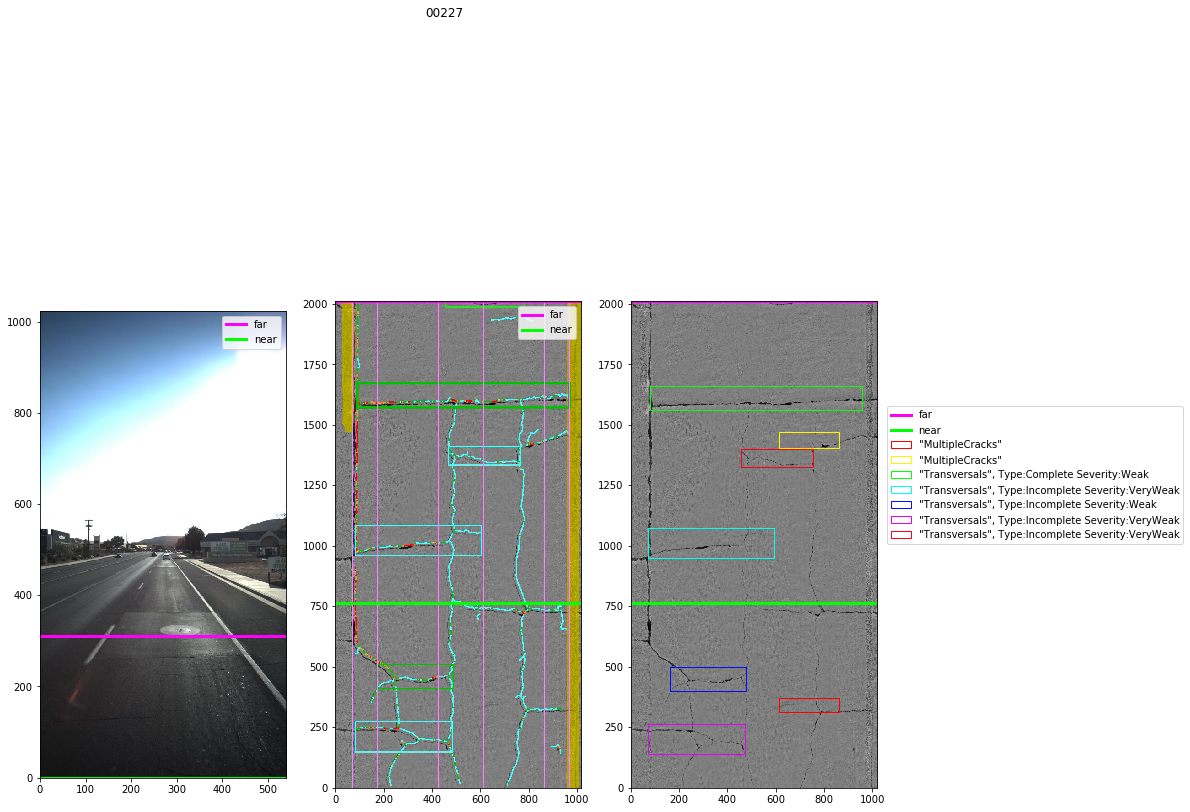

In [10]:
test_files_names = ['00227', '00228', '00229']
# test_files_names = ['00228']

test_files_names.reverse() # Reverse so viz appears as driving forward


mandli_data_dir_path = mandli_data_test_dir_path
filenames = test_files_names

for filename in filenames:
    file_LCMS_distress_xml = get_LCMS_distress_filepaths(mandli_data_dir_path, filename)[0]
    
    image_pixel_resolution_in_mm, unit_dict, crack_dict, crack_classification_dict = LCMS_crack_data_extraction(file_LCMS_distress_xml)
    print(crack_classification_dict)
    
    crack_viz_func = lambda filename, fig, ax1, ax2, ax3: viz_crack(filename, fig, ax1, ax2, ax3, crack_classification_dict)
    plot_front_and_visual_rng_and_rng(filename, mandli_data_dir_path, figsize=(15,15), rng_extra_plotting_func=crack_viz_func, legend_loc=(None,None,(1.04,0.5)))


# Filtering Cracks
- Will choose only "Transveral" cracks
- Will make sure bounding box of crack is between far and near
- Will look at only "Complete"and Severity being >= Weak

Will give visualization that will assist in manual labelling of "front" images using the visualization provided by the corresponding rng down images (these images will give the physical dimensions of each bounding boxed crack which can be joined to the "front" image).


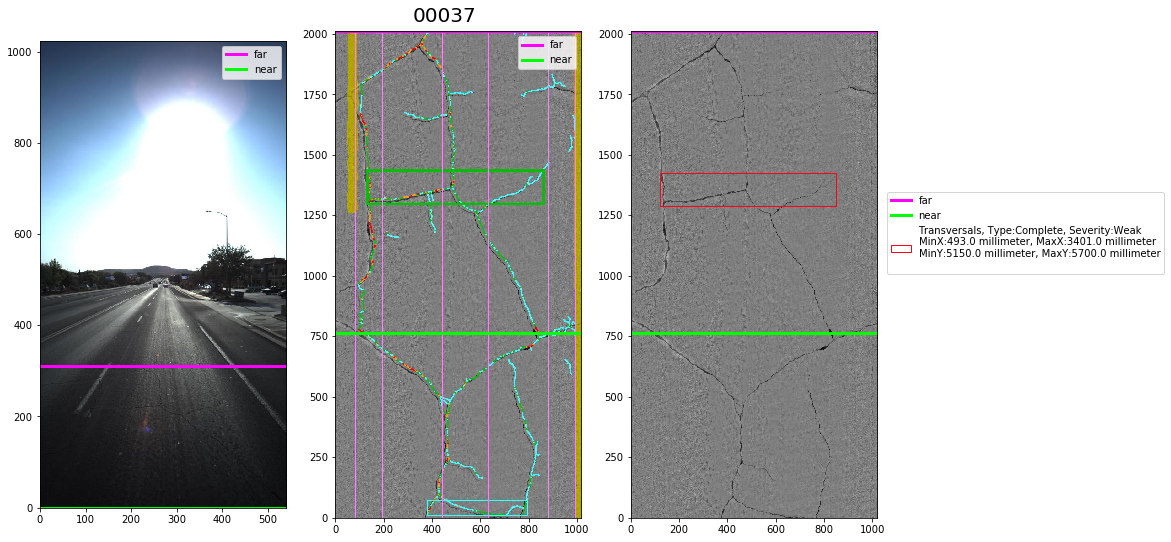

Path to front image: /cs6945share/mandli_data/0008_+/0008_+/Front/Dir_000/R_00037.jpg


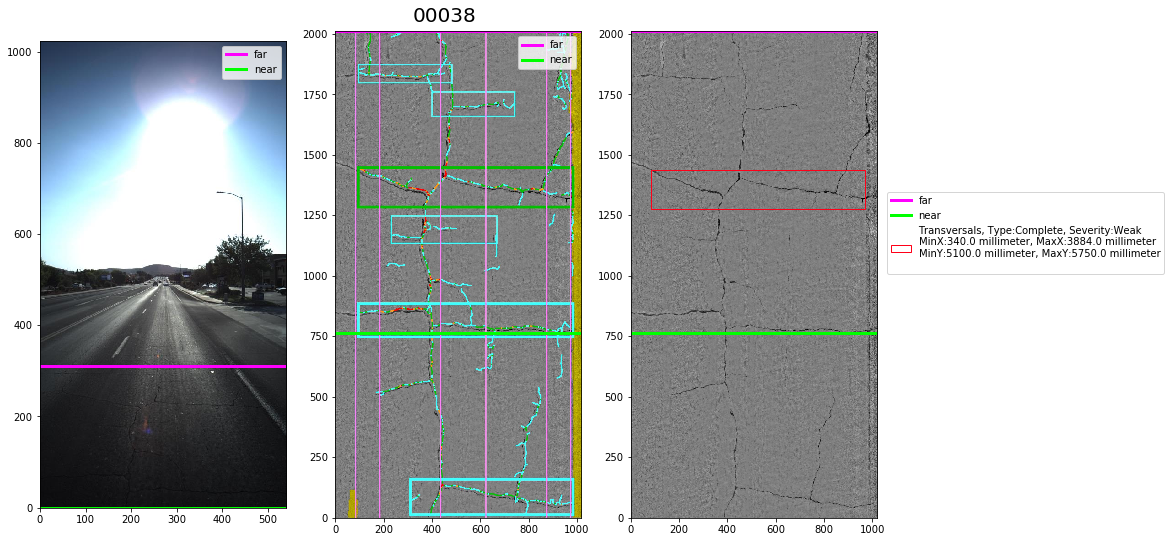

Path to front image: /cs6945share/mandli_data/0008_+/0008_+/Front/Dir_000/R_00038.jpg


In [ ]:
def mandli_data_viz_labeling_helper(mandli_data_dir_path, should_sort_by_name=True, **kwargs):
    name_list = get_name_list(mandli_data_dir_path, should_sort_by_name=should_sort_by_name)
    for name in name_list:
        mandli_data_viz_labeling_helper_single(name, mandli_data_dir_path, **kwargs)

def mandli_data_viz_labeling_helper_single(name, mandli_data_dir_path):
        # Get xml file given just the name (essentially undoing get_name_list but need name alone for rest of methods anyways so will do this anyway just for generality)
        file_LCMS_distress_xml = get_LCMS_distress_filepaths(mandli_data_dir_path, name)[0]
        file_front_img = get_front_img_filepaths(mandli_data_dir_path, name)[0]
        
        # Extract data contained in XML into more useful format
        image_pixel_resolution_in_mm, unit_dict, crack_dict, crack_classification_dict = LCMS_crack_data_extraction(file_LCMS_distress_xml)
        
        # Filter crack_classification_dict
        filtered_crack_classification_dict = filter_crack_classification_dict(crack_classification_dict)
        
        # If filtering gives no remaining info then return
        remaining_info_len = sum(len(val) for val in filtered_crack_classification_dict.values())
        if remaining_info_len == 0:
            return
        
        # Display front image on left, rng overlay image that comes with mandli data in middle, and filtered cracks on far right axis,
        crack_viz_func = lambda filename, fig, ax1, ax2, ax3: viz_crack_labeling_helper_plotting_extension(filename, fig, ax1, ax2, ax3, filtered_crack_classification_dict, unit_dict)
        plot_front_and_visual_rng_and_rng(name, mandli_data_dir_path, figsize=(15,15), rng_extra_plotting_func=crack_viz_func, legend_loc=(None,None,(1.04,0.5)), suptitle_pos=0.75, suptitle_fontsize=20)
        print('Path to front image: {0}'.format(os.path.abspath(file_front_img)))
        
def filter_crack_classification_dict(crack_classification_dict, near_y_limit = 763, far_y_limit=2012):
    filtered_crack_classification_dict = {}
    
    # Will choose only "Transveral" cracks
    transversals_info = crack_classification_dict['Transversals']
    
    filtered_transversals_info = []
    for info in transversals_info:
        # Will make sure bounding box of crack is between far and near
        if info['MaxY_pixel'] > far_y_limit or info['MinY_pixel'] < near_y_limit:
            continue
        # Will look at only "Complete"and Severity being >= Weak
        if (not info['Type'] == 'Complete') or info['Severity'] == 'VeryWeak':
            continue
        filtered_transversals_info.append(info)
    filtered_crack_classification_dict['Transversals'] = filtered_transversals_info
    return filtered_crack_classification_dict

def viz_crack_labeling_helper_plotting_extension(filename, fig, ax1, ax2, ax3, crack_classification_dict, unit_dict, desired_info_to_display={'Type','Severity'}):
    i = 0
    cmap = get_cmap(sum(len(val) for val in crack_classification_dict.values()))
    for key in crack_classification_dict:
        info = crack_classification_dict[key]
        for single_crack_classification_info_dict in info:
            legend_string = '{0}'.format(key)
            for info_key in single_crack_classification_info_dict:
                if not info_key in desired_info_to_display:
                    continue
                legend_string += ', {0}:{1}'.format(info_key, single_crack_classification_info_dict[info_key])
            legend_string += '\n'
            legend_string += 'MinX:{0} {2}, MaxX:{1} {2}\n'.format(single_crack_classification_info_dict['MinX'], single_crack_classification_info_dict['MaxX'], unit_dict['X'])
            legend_string += 'MinY:{0} {2}, MaxY:{1} {2}\n'.format(single_crack_classification_info_dict['MinY'], single_crack_classification_info_dict['MaxY'], unit_dict['Y'])
            viz_bounding_box(ax3, single_crack_classification_info_dict, linewidth=1, edgecolor=cmap(i), facecolor='none', name=legend_string)
            i += 1        
    
def get_name_list(mandli_data_dir_path, should_sort_by_name=True):        
    name_list = []
    for xml_filepath in glob.glob(os.path.join(os.path.join(mandli_data_dir_path, 'LCMSDistress'), '*.xml'), recursive=True):
        xml_filename = os.path.basename(xml_filepath)
        name = re.search('_0(.+?).xml', xml_filename)
        if name:
            name = name.group(1)
        name_list.append(name)
    if should_sort_by_name:
        name_list.sort()
    return name_list
        
mandli_data_viz_labeling_helper(mandli_data_test_dir_path, should_sort_by_name=True)

    

# Next Steps
Need more data like the test folder, then can label manually using Blyncsy labelling tool, adding special annotation for the bounding box dimensions in physical units